# Vivarium *E. coli* API Demo

In [1]:
from vivarium.core.process import Process
from vivarium.core.store import Store
from vivarium.core.engine import Engine, pp
from vivarium.plots.topology import plot_topology
from vivarium.plots.simulation_output import plot_variables

## Load the required components

To run an E. coli model, you need a few things:
 * **sim_data**: the model parameters from wcEcoli.
 * **initial_state**: the initial state of the system -- a snapshot from wcEcoli.
 * **processes**: the modular processes, which are wired together to create the full model.

### Load sim_data

In [2]:
# Make sure this is running out of vivarium-ecoli directory
import sys

sys.path[0] += '/..'
sys.path

['/Users/abhinavkumar/code/vivarium-ecoli/notebooks/..',
 '/Users/abhinavkumar/.pyenv/versions/3.8.5/lib/python38.zip',
 '/Users/abhinavkumar/.pyenv/versions/3.8.5/lib/python3.8',
 '/Users/abhinavkumar/.pyenv/versions/3.8.5/lib/python3.8/lib-dynload',
 '',
 '/Users/abhinavkumar/.pyenv/versions/3.8.5/envs/v-ecoli/lib/python3.8/site-packages',
 '/Users/abhinavkumar/.pyenv/versions/3.8.5/envs/v-ecoli/lib/python3.8/site-packages/Build_sequences-0.0.0-py3.8-macosx-11.4-x86_64.egg',
 '/Users/abhinavkumar/.pyenv/versions/3.8.5/envs/v-ecoli/lib/python3.8/site-packages/Monte_carlo_complexation-0.0.0-py3.8-macosx-11.4-x86_64.egg',
 '/Users/abhinavkumar/.pyenv/versions/3.8.5/envs/v-ecoli/lib/python3.8/site-packages/Fast_polymerize_sums-0.0.0-py3.8-macosx-11.4-x86_64.egg',
 '/Users/abhinavkumar/.pyenv/versions/3.8.5/envs/v-ecoli/lib/python3.8/site-packages/vivarium_ecoli-0.0.1-py3.8.egg',
 '/Users/abhinavkumar/.pyenv/versions/3.8.5/envs/v-ecoli/lib/python3.8/site-packages/aesara-2.0.8-py3.8.egg',


In [3]:
from ecoli.library.sim_data import LoadSimData

SIM_DATA_PATH = '../reconstruction/sim_data/kb/simData.cPickle'

load_sim_data = LoadSimData(
            sim_data_path=SIM_DATA_PATH,
            seed=0)

### Load specific process parameters from sim_data

In [4]:
transcript_initiation_params = load_sim_data.get_transcript_initiation_config()
transcript_elongation_params = load_sim_data.get_transcript_elongation_config()

### Get initial state snapshot

In [5]:
from ecoli.composites.ecoli_master import get_state_from_file

INITIAL_STATE_PATH = '../data/wcecoli_t0.json'

initial_state = get_state_from_file(path=INITIAL_STATE_PATH)

## Make processes by loading in parameters

In [6]:
from ecoli.processes.transcript_initiation import TranscriptInitiation
from ecoli.processes.transcript_elongation import TranscriptElongation

transcript_initiation = TranscriptInitiation(transcript_initiation_params)
transcript_elongation = TranscriptElongation(transcript_elongation_params)

### View a process' ports schema
The port schema defines a systems ports (top-level keys), and the expected behavior of molecules under that port (its *schema*).

In [7]:
pp(transcript_initiation.ports_schema())

{ 'RNAs': { '*': { 'RNAP_index': {'_default': 0, '_updater': 'set'},
                   'TU_index': {'_default': 0, '_updater': 'set'},
                   'can_translate': {'_default': 0, '_updater': 'set'},
                   'is_full_transcript': {'_default': 0, '_updater': 'set'},
                   'is_mRNA': {'_default': 0, '_updater': 'set'},
                   'transcript_length': { '_default': 0,
                                          '_emit': True,
                                          '_updater': 'set'},
                   'unique_index': {'_default': 0, '_updater': 'set'}}},
  'active_RNAPs': { '*': { 'coordinates': { '_default': 0,
                                            '_emit': True,
                                            '_updater': 'set'},
                           'direction': {'_default': 0, '_updater': 'set'},
                           'domain_index': {'_default': 0, '_updater': 'set'},
                           'unique_index': {'_default': 0, '_up

### Run an individual process with minimal parameter set
A nice aspect of process modularity is that each can be configured with parameters that are not dependent on `sim_data`, and an arbitrary initial state. This supports easy access to parameters, which can be directly modified by learning algorithms.


Simulation ID: 92a064fa-f184-11eb-b6df-3c15c2dc0586
Created: 07/30/2021 at 15:22:06
Completed in 0.012698 seconds

simulation output:
{ 'A': [10, 14, 15, 17, 20, 21, 13, 18, 21, 23, 22, 22, 23, 22, 25, 21],
  'B': [20, 19, 21, 16, 18, 17, 20, 20, 16, 20, 20, 21, 21, 22, 18, 20],
  'C': [30, 27, 24, 27, 22, 22, 27, 22, 23, 17, 18, 17, 16, 16, 17, 19]}


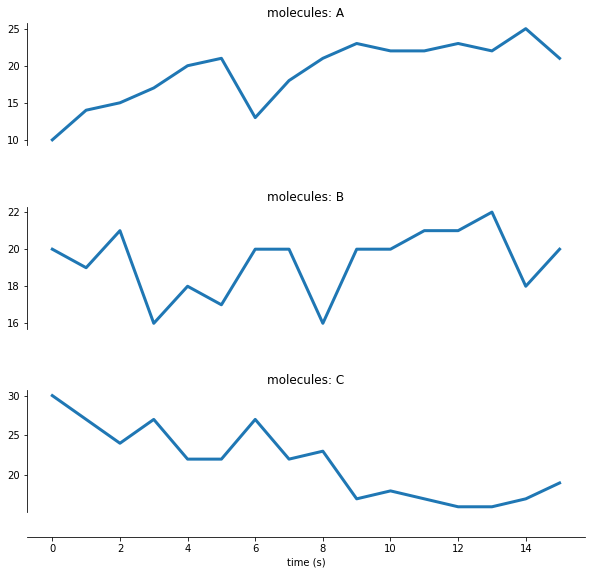

In [8]:
import numpy as np
from vivarium.core.composition import simulate_process
from ecoli.processes.complexation import Complexation

# define parameters
test_params = {
    'stoichiometry': np.array([
        [-1, 1, 0],
        [0, -1, 1],
        [1, 0, -1],
        [-1, 0, 1],
        [1, -1, 0],
        [0, 1, -1]], np.int64),
    'rates': np.array([1, 1, 1, 1, 1, 1], np.float64),
    'molecule_names': ['A', 'B', 'C'],
    'seed': 1}

# define initial state
initial_complexation_state = {
    'molecules': {
        'A': 10,
        'B': 20,
        'C': 30}}

# initialize the process
complexation_process = Complexation(test_params)

# run simulation and retrieve final data
settings = {
    'total_time': 15,
    'initial_state': initial_complexation_state}
data = simulate_process(complexation_process, settings)

print('\nsimulation output:')
pp(data['molecules'])

# plot output
fig = plot_variables(
    data, 
    variables=[
        ('molecules', 'A'), 
        ('molecules', 'B'), 
        ('molecules', 'C')],
    column_width=10, row_height=3, row_padding=0.5)

## Compose a multiscale model

TODO: demonstrate how to wire up a model by hand.

In [9]:
# from ecoli.composites.ecoli_master import ECOLI_TOPOLOGY

# # create an empty "cell" store
# cell = Store({})

# # generate a path and add a process in the leaf
# cell.create(
#     ['cytoplasm', 'transcript_initiation'], 
#     transcript_initiation, 
#     topology=ECOLI_TOPOLOGY['transcript_initiation'])

# cell.create(
#     ['cytoplasm', 'transcript_elongation'], 
#     transcript_elongation, 
#     topology=ECOLI_TOPOLOGY['transcript_elongation'])

ImportError: cannot import name 'ECOLI_TOPOLOGY' from 'ecoli.composites.ecoli_master' (/Users/abhinavkumar/code/vivarium-ecoli/notebooks/../ecoli/composites/ecoli_master.py)

### TODO: put the model in an Engine

### TODO: run the simulation

### TODO: retrieve the data

## Ecoli master composite

### load the composer
 * A `Composer` is a class that generates `Composite` models, with many processes wired together through shared `Stores`.
 * `Ecoli` is the current master composite of the E. coli model.

In [10]:
from ecoli.composites.ecoli_master import Ecoli

ecoli_config = {
    'agent_id': '1',
    '_schema': {
        'equilibrium': {
            'molecules': {
                'PD00413[c]': {
                    '_updater': 'nonnegative_accumulate'
                }
            }
        }
    },
    'sim_data_path': SIM_DATA_PATH}
ecoli_composer = Ecoli(ecoli_config)

### Plot Ecoli's topology

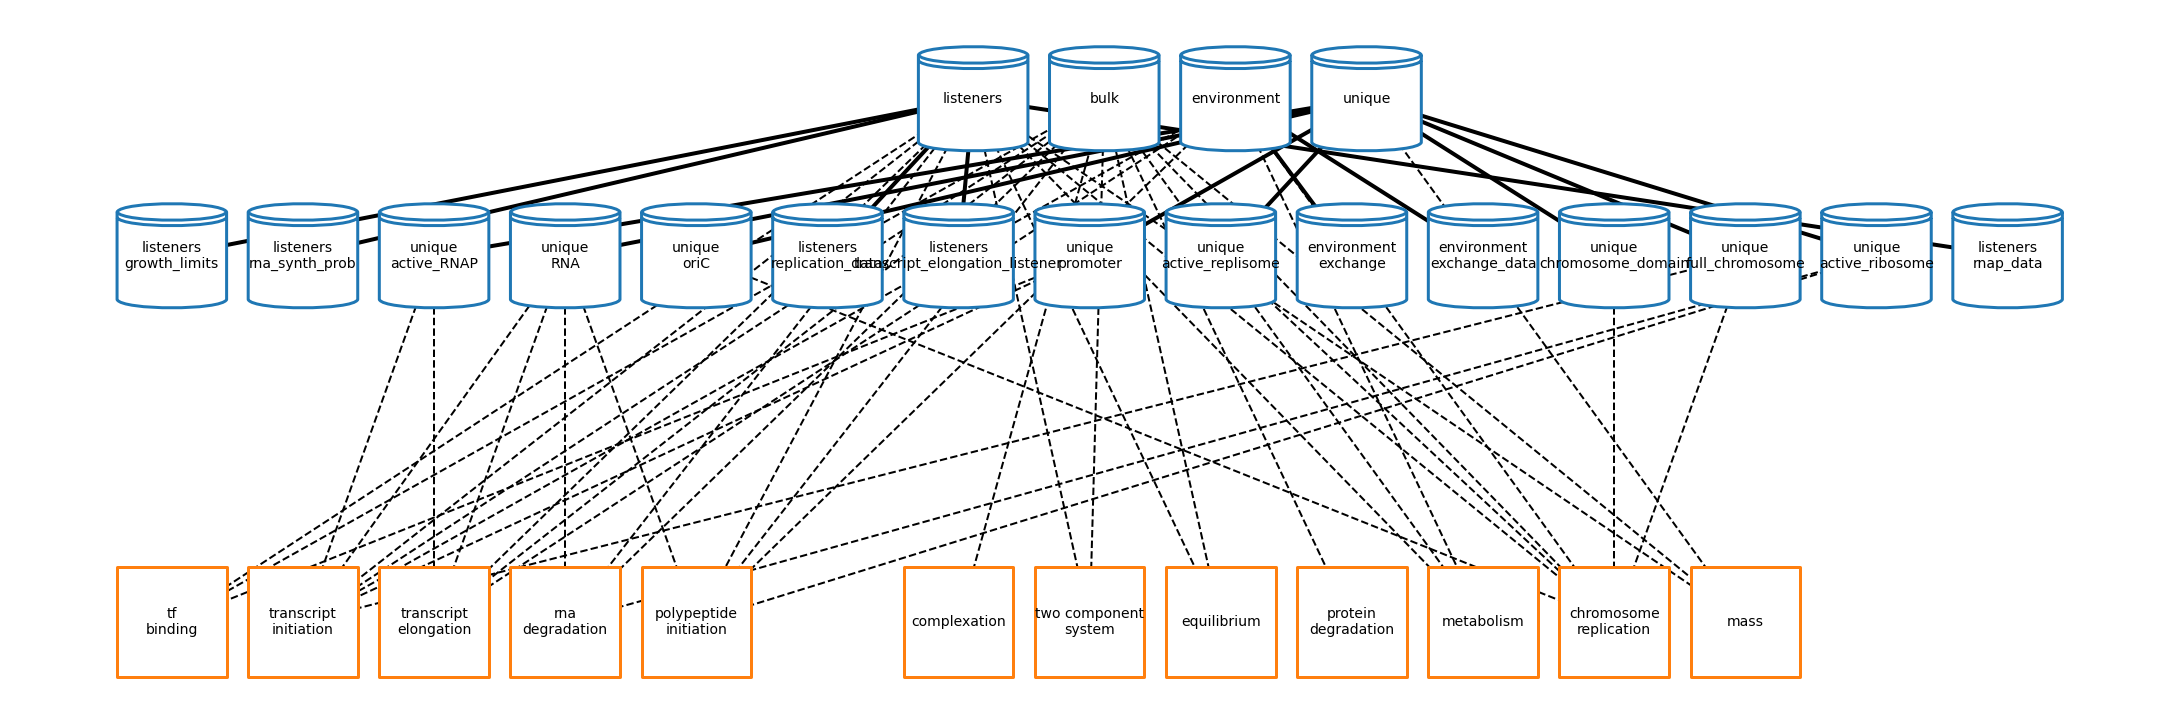

In [11]:
from ecoli.composites.ecoli_master import ecoli_topology_plot
topology_plot = ecoli_topology_plot(config=ecoli_config)

## Initialize the simulation

In [12]:
ecoli = ecoli_composer.generate()
ecoli_simulation = Engine({
    'processes': ecoli.processes,
    'topology': ecoli.topology,
    'initial_state': initial_state,
    'progress_bar': True,
})


Simulation ID: c8a1434e-f184-11eb-b6df-3c15c2dc0586
Created: 07/30/2021 at 15:23:42


/Users/abhinavkumar/.pyenv/versions/3.8.5/envs/v-ecoli/lib/python3.8/site-packages/vivarium_core-0.3.1-py3.8.egg/vivarium/core/engine.py:362: UserWarning: configuration size is too big for the emitter, discarding process parameters
  warnings.warn('configuration size is too big for the emitter, '


### Run the simulation

In [13]:
total_time = 10
ecoli_simulation.update(total_time)

Progress:|██████████████████████████████████████████████████| 0.0/10.0 simulated seconds remaining    
Completed in 40.24 seconds


### Retrieve the simulation output

In [14]:
# retrieve it in "data" format 
ecoli_sim_data = ecoli_simulation.emitter.get_data()

# retrieve it in "timeseries" format 
ecoli_sim_timeseries = ecoli_simulation.emitter.get_timeseries()

{ 'cell_mass': [ 1166.0428635190078,
                 1166.2134557209909,
                 1166.347752666424,
                 1166.5300830794795,
                 1166.7306295517349,
                 1166.9979809293045],
  'dry_mass': [ 346.6131797067766,
                346.62080024745785,
                346.63388543151893,
                346.7005984146607,
                346.76123571570463,
                346.8533024882197],
  'water_mass': [ 819.4296838122312,
                  819.592655473533,
                  819.713867234905,
                  819.8294846648188,
                  819.9693938360302,
                  820.1446784410848]}


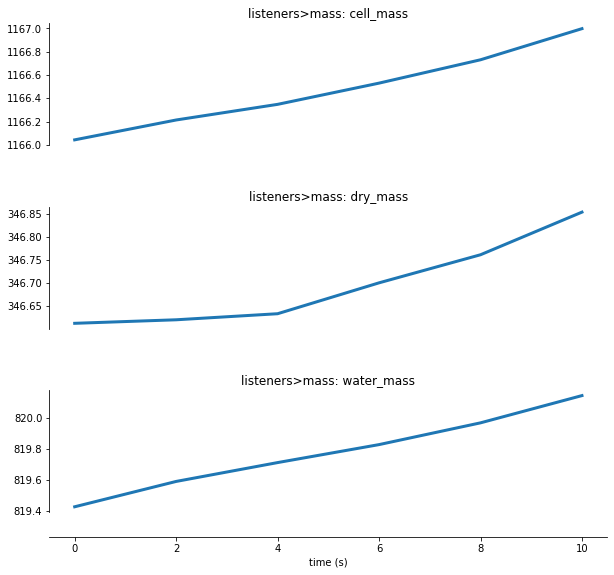

In [15]:
# print output of the mass store under listeners
pp(ecoli_sim_timeseries['listeners']['mass'])

# plot output
fig = plot_variables(
    ecoli_sim_timeseries, 
    variables=[
        ('listeners', 'mass','cell_mass'), 
        ('listeners', 'mass','dry_mass'), 
        ('listeners', 'mass','water_mass')],
    column_width=10, row_height=3, row_padding=0.5)